# DDoS attacks detection and characterization

First, we need to import the necessary libraries.

In [2]:
# import needed python libraries

%matplotlib inline

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor

## Data exploration and pre-processing
Now, we load the dataset from the .csv file provided.

In [3]:
# Load the dataset
df = pd.read_csv("ddos_dataset.csv", header=0, index_col=0, engine='python')

# Remove leading and trailing spaces from column names
df.columns = df.columns.str.strip()

df


,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,SimillarHTTP,Inbound,label
0,172.16.0.5-192.168.50.1-634-60495-17,172.16.0.5,634,192.168.50.1,60495,17,2018-12-01 10:51:39.813448,28415,97,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_dns
1,172.16.0.5-192.168.50.1-60495-634-17,192.168.50.1,634,172.16.0.5,60495,17,2018-12-01 10:51:39.820842,2,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,ddos_dns
2,172.16.0.5-192.168.50.1-634-46391-17,172.16.0.5,634,192.168.50.1,46391,17,2018-12-01 10:51:39.852499,48549,200,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_dns
3,172.16.0.5-192.168.50.1-634-11894-17,172.16.0.5,634,192.168.50.1,11894,17,2018-12-01 10:51:39.890213,48337,200,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_dns
4,172.16.0.5-192.168.50.1-634-27878-17,172.16.0.5,634,192.168.50.1,27878,17,2018-12-01 10:51:39.941151,32026,200,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_dns
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65995,172.16.0.5-192.168.50.1-38625-63051-17,172.16.0.5,38625,192.168.50.1,63051,17,2018-12-01 13:04:46.628249,1,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_udp_lag
65996,172.16.0.5-192.168.50.1-58632-18963-17,172.16.0.5,58632,192.168.50.1,18963,17,2018-12-01 13:04:46.628963,212238,6,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_udp_lag
65997,172.16.0.5-192.168.50.1-46104-64704-17,172.16.0.5,46104,192.168.50.1,64704,17,2018-12-01 13:04:46.629014,1,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_udp_lag
65998,172.16.0.5-192.168.50.1-60686-10440-17,172.16.0.5,60686,192.168.50.1,10440,17,2018-12-01 13:04:46.629016,108952,4,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_udp_lag


### Removing inconsistent features
From the previous visualization analysis, we discovered that some features are inconsistent, duplicated or don't bring any further information (since they are always 0), so, as first preprocessing step, we drop them. At the end, we removed 20 features.

In [4]:
columns_to_delete = ['Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Header Length.1', 'min_seg_size_forward', 'Fwd Avg Bytes/Bulk',  'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk',  'Bwd Avg Packets/Bulk',  'Bwd Avg Bulk Rate', 'PSH Flag Count', 'FIN Flag Count', 'ECE Flag Count', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags']
print(f"Removed features: {columns_to_delete}")
df_cleaned = df.drop(columns_to_delete, axis=1)

df_cleaned.describe()

Removed features: ['Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Header Length.1', 'min_seg_size_forward', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate', 'PSH Flag Count', 'FIN Flag Count', 'ECE Flag Count', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags']


,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,...,act_data_pkt_fwd,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Inbound
count,64239.000000,64239.000000,64239.000000,6.423900e+04,64239.000000,64239.000000,64239.000000,6.423900e+04,64239.000000,64239.000000,...,64239.000000,6.423900e+04,6.423900e+04,6.423900e+04,6.423900e+04,6.423900e+04,6.423900e+04,6.423900e+04,6.423900e+04,64239.000000
mean,25267.368608,30715.252884,14.362864,5.150614e+06,18.814848,1.304036,6699.521630,2.153348e+03,613.992948,588.863043,...,13.416881,9.026629e+03,4.878774e+03,1.687791e+04,6.204895e+03,1.155553e+06,2.613584e+05,1.555321e+06,8.908522e+05,0.919566
std,24710.413442,20347.990914,4.706001,2.249713e+07,462.305336,25.199720,20510.320389,9.087201e+04,585.691655,584.276284,...,46.777592,2.045563e+05,1.424082e+05,3.828583e+05,1.667756e+05,5.341380e+06,1.574889e+06,6.993415e+06,4.571276e+06,0.271966
min,0.000000,0.000000,0.000000,1.000000e+00,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,779.000000,12435.500000,17.000000,1.000000e+00,2.000000,0.000000,123.000000,0.000000e+00,53.000000,36.000000,...,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000
50%,29661.000000,30797.000000,17.000000,2.000000e+00,2.000000,0.000000,1050.000000,0.000000e+00,393.000000,375.000000,...,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000
75%,48510.500000,49041.500000,17.000000,2.087700e+04,2.000000,0.000000,2944.000000,0.000000e+00,1464.000000,1464.000000,...,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000
max,65518.000000,65535.000000,17.000000,1.200000e+08,85894.000000,1862.000000,176000.000000,8.829488e+06,3564.000000,2020.000000,...,399.000000,1.678654e+07,2.853681e+07,6.783473e+07,8.349846e+06,1.147455e+08,5.275036e+07,1.147455e+08,1.147455e+08,1.000000


### 1.3.1 Correlation analysis
In order to analyze the correlation, we need to compute the correlation between each pair of features, which can be done using the pandas function ``.corr()`` (<a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html?highlight=corr#pandas.DataFrame.corr">documentation</a>). It calculate the Pearson correlation coefficient (<a href="https://en.wikipedia.org/wiki/Pearson_correlation_coefficient">Wiki</a>) between two numerical features, which is a value between -1 and 1. Normally, we take the absolute value, and the closer to 1 the higher the correlation.
$$ r = \frac{n(\sum xy) - (\sum x)(\sum y)}{\sqrt{[n\sum x^2 - (\sum x)^2][n\sum y^2 - (\sum y)^2]}} $$
<!-- $$ r = \frac{\sum (x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum (x_i - \bar{x})^2} \sqrt{\sum (y_i - \bar{y})^2}} $$ -->
The result of correlation analysis can be displayed in a heatmap (<a href="https://seaborn.pydata.org/generated/seaborn.heatmap.html">documentation</a>), which is a symmetric matrix, indicating the correlation coefficient between each pair of features (even a feature with itself).

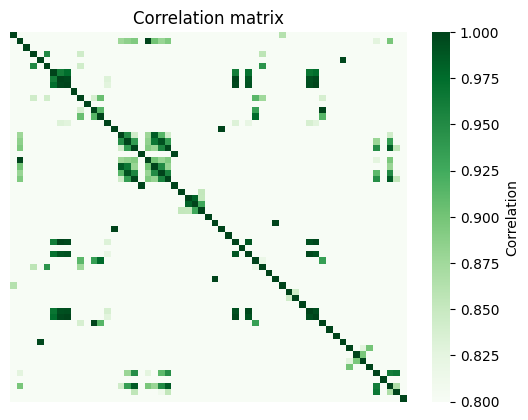

Original dataset: (64239, 67)
Cleaned dataset: (64239, 59)


,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Inbound
0,17,28415,97,0,42680.0,0.0,440.0,440.0,440.0,0.000000,...,96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,17,2,2,0,880.0,0.0,440.0,440.0,440.0,0.000000,...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,17,48549,200,0,88000.0,0.0,440.0,440.0,440.0,0.000000,...,199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,17,48337,200,0,88000.0,0.0,440.0,440.0,440.0,0.000000,...,199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,17,32026,200,0,88000.0,0.0,440.0,440.0,440.0,0.000000,...,199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65995,17,1,2,0,750.0,0.0,375.0,375.0,375.0,0.000000,...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
65996,17,212238,6,0,2088.0,0.0,393.0,321.0,348.0,35.088460,...,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
65997,17,1,2,0,750.0,0.0,375.0,375.0,375.0,0.000000,...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
65998,17,108952,4,0,1438.0,0.0,389.0,330.0,359.5,34.063666,...,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [84]:
# Select the numerical and categorical features
categorical_features = df_cleaned.select_dtypes(exclude=['number']).columns.tolist()
categorical_features.append('Source Port')
categorical_features.append('Destination Port')
numerical_features = [col for col in df_cleaned.columns if col not in categorical_features]

# Verifica e conversione forzata a numerico (ignorando errori di conversione)
df_numerical = df_cleaned[numerical_features].apply(pd.to_numeric, errors='coerce')

# Questa parte ora è inutile, le abbiamo già eliminate prima
# Calcolo della varianza per identificare le feature valide (con varianza maggiore di 0)
#df_filtered = df_clean.loc[:, df_clean.var() > 0]       # poiché queste feature non contribuiscono alla correlazione e possono introdurre rumore

# Compute the correlation matrix
correlation_matrix = df_numerical.corr().abs()
#correlation_matrix = df.drop(columns=categorical_features).corr().abs()    # we take the absolute value to focus on the strength of the correlation

# Compute the heatmap (correlation matrix)
plt.figure()
sns.heatmap(correlation_matrix, cmap='Greens', vmin=0.8, vmax=1, xticklabels=False, yticklabels=False , cbar_kws={'label':'Correlation'})      # we show the correlation when it is > 0.8
plt.title('Correlation matrix')
plt.show()

print("Original dataset:", df_cleaned.shape)
print("Cleaned dataset:", df_numerical.shape)
df_numerical

### Principal Component Analysis (PCA)
Use a number components where you meet the elbow point. i.e., if increasing the number of components does not increase much the cumulative explained variance. Remember: it is essential to perform data standardization before performing PCA.

<>:27: SyntaxWarning: invalid escape sequence '\s'
<>:27: SyntaxWarning: invalid escape sequence '\s'
/var/folders/x0/vppspl391z3_qp7t8q5lczn00000gn/T/ipykernel_7005/2275674180.py:27: SyntaxWarning: invalid escape sequence '\s'
  plt.title(f'{PC_number} PCs explain {round(perc_cumul_exp_var[PC_number-1], 2)}% of $\sigma^2$')        # round(perc_cumul_exp_var[x], 2) calculates the percentage explained by the first x PCs


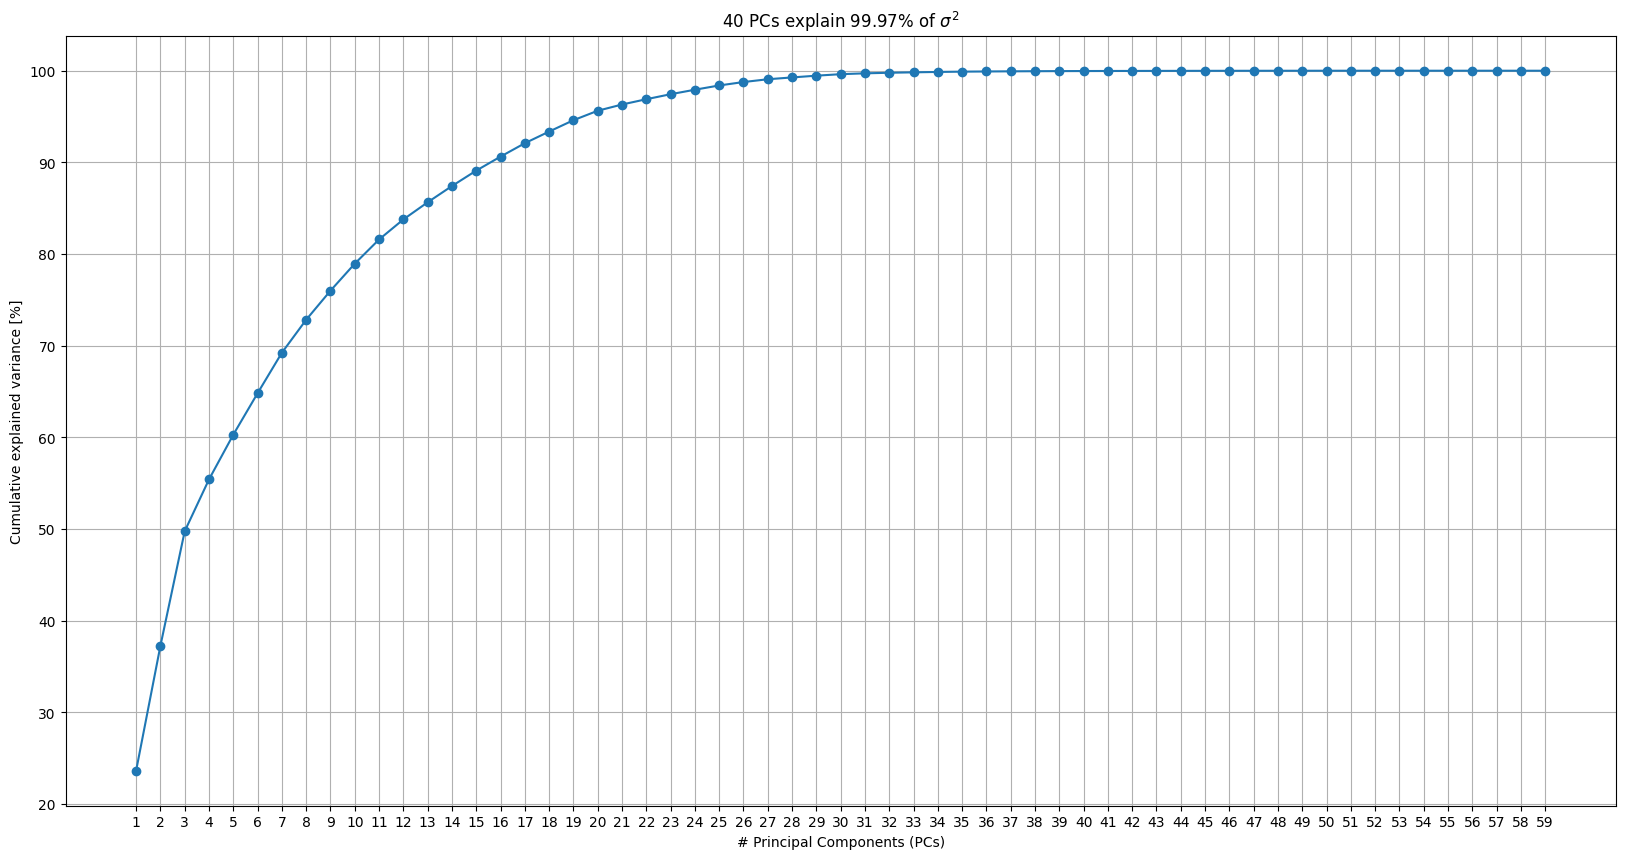

In [6]:
# Create a copy of the original dataset
df_copy = df_cleaned.copy()

# Data standardization
scaler = StandardScaler()
df_copy[numerical_features] = scaler.fit_transform(df_copy[numerical_features])

pca = PCA(random_state=42)      # PCA must be initialized with a random state to initialize the space
pca.fit(df_copy[numerical_features].dropna())   # compute the new dimensions with number of features from 1 to the number of original features
                                                # .dropna() is for deleting NaN values


explained_variance = pca.explained_variance_ratio_      # describe how much of the dataset variability is indicated by a given amount of features
cumul_exp_var = np.cumsum(explained_variance)       # evaluate the total dataset variability while increasing the variables
perc_cumul_exp_var = cumul_exp_var * 100        # percentage value to better understand the best number of components

# Set the number of PC to take
PC_number = 40

# Make the plot of cumulative explained variance with respect to number of components
plt.figure(figsize=(20,10))
plt.plot(perc_cumul_exp_var, marker='o')
plt.xlabel('# Principal Components (PCs)')
plt.ylabel('Cumulative explained variance [%]')
plt.xticks([i for i in range(len(numerical_features))], [i for i in range(1,len(numerical_features)+1)])
plt.grid()
plt.title(f'{PC_number} PCs explain {round(perc_cumul_exp_var[PC_number-1], 2)}% of $\sigma^2$')        # round(perc_cumul_exp_var[x], 2) calculates the percentage explained by the first x PCs
plt.show()



### PCA transformation

In [7]:
# initialize the PCA with the best number of components, in this case, it's 40
pca = PCA(n_components=40, random_state=42)

# fit the data to new space
pca.fit(df_copy[numerical_features])        # it determines the directions along which the data varies the most

# transform the original data into PCA components
pca_result = pca.transform(df_copy[numerical_features])

# create the new dataset
new_columns = [f'PC{i}' for i in range(1, PC_number+1)]
df_pca = pd.DataFrame(pca_result, columns=new_columns)           # pd.DataFrame(...): crea un nuovo DataFrame con i dati trasformati, utilizzando le colonne denominate 'component_1', 'component_2', e 'component_3'

# We need to reset the index to make the labels match the samples (otherwise it tries to match it by indexes, but in the original df they're non-contigous)
df_pca1 = df_pca.reset_index(drop=True)
df_cleaned2 = df_cleaned.reset_index(drop=True)
df_pca = pd.concat([df_pca1, df_cleaned2['label']], axis=1)

# Save the transformed dataset in a csv file to reuse it in the next jupyter notebook
df_pca.to_csv("pca_dataset.csv")

df_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,label
0,-0.284227,-1.031528,-0.847474,-0.174401,-0.867714,2.738893,-1.021160,0.572375,-0.200909,-0.113964,...,-0.016240,0.004520,-0.007726,-0.000549,-0.003569,0.017081,-0.043824,-0.007183,0.000671,ddos_dns
1,-0.334613,-0.665187,-0.962476,0.405087,0.461767,0.124486,0.106917,-0.091467,-0.061478,0.092113,...,0.047349,-0.064328,0.045066,0.027939,0.008969,-0.026256,0.016200,0.037482,0.021847,ddos_dns
2,-0.307742,-1.144423,-0.991048,-0.167760,-1.485189,4.775312,-1.786339,1.240988,-0.564195,-0.127972,...,-0.013193,0.007981,0.001997,0.018305,-0.012399,0.012201,-0.025050,-0.007868,0.007056,ddos_dns
3,-0.307909,-1.144464,-0.991139,-0.167737,-1.485196,4.775309,-1.786288,1.240995,-0.564174,-0.127970,...,-0.013447,0.007836,0.002022,0.018268,-0.012515,0.012159,-0.025048,-0.007888,0.007066,ddos_dns
4,-0.309101,-1.144294,-0.990969,-0.167914,-1.485369,4.773705,-1.784758,1.241510,-0.564316,-0.128338,...,-0.013766,0.007661,0.002087,0.018267,-0.012464,0.012106,-0.025024,-0.007791,0.007097,ddos_dns
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64234,-0.771804,-0.805534,-0.358899,-0.476012,-0.524117,-0.706794,1.034228,0.430967,-0.026979,-0.522731,...,-0.009887,0.013770,-0.002440,0.007576,0.001982,0.001835,-0.005733,-0.004297,0.001123,ddos_udp_lag
64235,0.001752,-0.993832,-1.015435,-0.196162,-0.371376,0.959232,-0.221572,0.026344,0.086233,0.215038,...,0.036509,-0.037440,0.007034,-0.013158,0.003226,-0.024392,0.063594,0.018227,-0.013548,ddos_udp_lag
64236,-0.771804,-0.805534,-0.358899,-0.476012,-0.524117,-0.706794,1.034228,0.430967,-0.026979,-0.522731,...,-0.009887,0.013770,-0.002440,0.007576,0.001982,0.001835,-0.005733,-0.004297,0.001123,ddos_udp_lag
64237,-0.022837,-0.974232,-0.985986,-0.190383,-0.352925,0.924495,-0.218127,0.009171,0.093423,0.208569,...,0.037133,-0.034376,0.004909,-0.013977,0.000990,-0.022780,0.067008,0.013820,-0.007303,ddos_udp_lag


### Loading score
The loading score can be used to extract the coefficients of the linear combination of the original variables from which the principal components (PCs) are constructed. It can describe how strongly a component describes the original features and identify potentially redundant features in for a given component. Note that the score is computed as ``pca.components_.T * np.sqrt(pca.explained_variance_)``.

<>:20: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\s'
/var/folders/x0/vppspl391z3_qp7t8q5lczn00000gn/T/ipykernel_7005/1816972248.py:20: SyntaxWarning: invalid escape sequence '\s'
  plt.title(f'{PC_number} PCs explain {round(perc_cumul_exp_var[PC_number-1], 2)}% of $\sigma^2$')


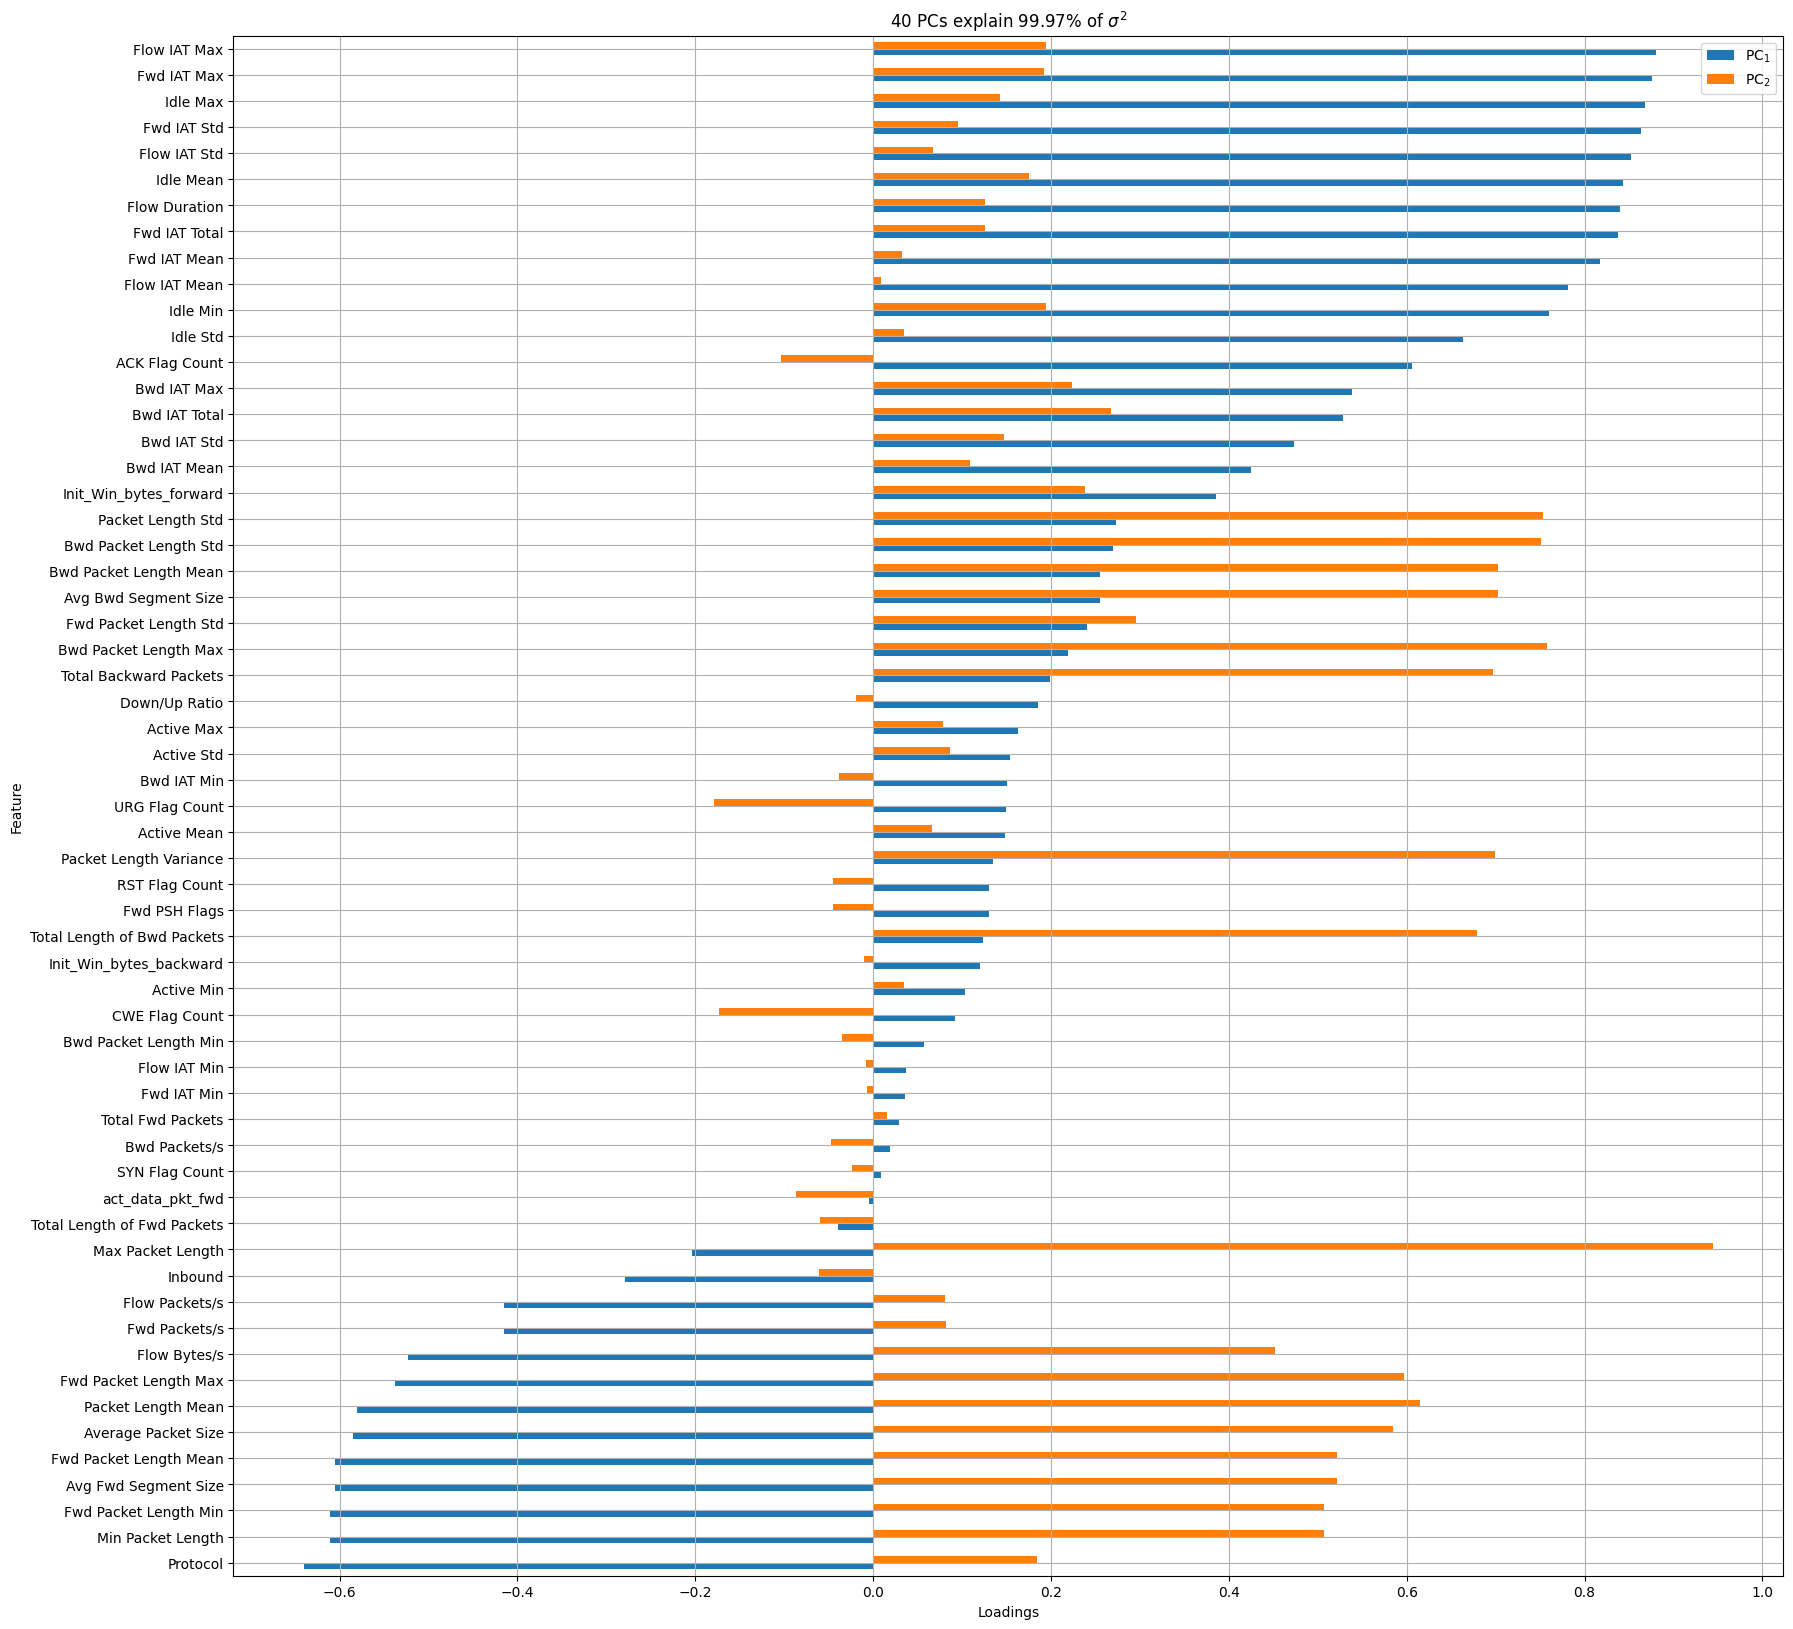

In [8]:
# NOTA: i loading scores rappresentano il contributo di ciascuna feature originale a ciascun componente principale.
# Un loading score alto (sia positivo che negativo) indica che quella particolare feature contribuisce fortemente
# alla direzione di quel componente principale.
# Questi punteggi aiutano a capire quali variabili originali influenzano maggiormente ciascun componente principale,
# fornendo così informazioni sulle caratteristiche principali che descrivono i dati ridotti.

# Compute the loading scores and create the dataframe
loadings = pd.DataFrame(
    data = pca.components_.T * np.sqrt(pca.explained_variance_),
    columns = new_columns,
    index = numerical_features
)

plt.figure(figsize=(20,20))
loadings = loadings[['PC1', 'PC2']]     # seleziona solo i loading scores per i primi due componenti principali
loadings.sort_values(['PC1', 'PC2']).rename(columns={'PC1':'PC$_{1}$', 'PC2':'PC$_{2}$'}).plot.barh(ax=plt.gca())
plt.grid()
plt.xlabel('Loadings')
plt.ylabel('Feature')
plt.title(f'{PC_number} PCs explain {round(perc_cumul_exp_var[PC_number-1], 2)}% of $\sigma^2$')
plt.show()


### 1.3.2 Label encoding
Use One-Hot Encoding for supervised multiclass classification, since supervised machine learning models cannot directly interpret categorical features.

In [9]:
'''
# One-Hot Encoding for the 'label' column
encoded_df = pd.get_dummies(df_cleaned['label'], prefix='label')    # transform each unique value of the label column into a separate binary column
df_encoded = pd.concat([df_cleaned, encoded_df], axis=1)        # add the new binary columns to the original dataframe
df_encoded.drop(columns=['label'], inplace=True)        # remove the original label column, as it has been replaced by binary columns


# Set Pandas to show all columns
pd.set_option('display.max_columns', None)

# Display the first rows of the dataset
print(df_encoded.head())

# Restore default limit
pd.reset_option('display.max_columns')
'''

"\n# One-Hot Encoding for the 'label' column\nencoded_df = pd.get_dummies(df_cleaned['label'], prefix='label')    # transform each unique value of the label column into a separate binary column\ndf_encoded = pd.concat([df_cleaned, encoded_df], axis=1)        # add the new binary columns to the original dataframe\ndf_encoded.drop(columns=['label'], inplace=True)        # remove the original label column, as it has been replaced by binary columns\n\n\n# Set Pandas to show all columns\npd.set_option('display.max_columns', None)\n\n# Display the first rows of the dataset\nprint(df_encoded.head())\n\n# Restore default limit\npd.reset_option('display.max_columns')\n"

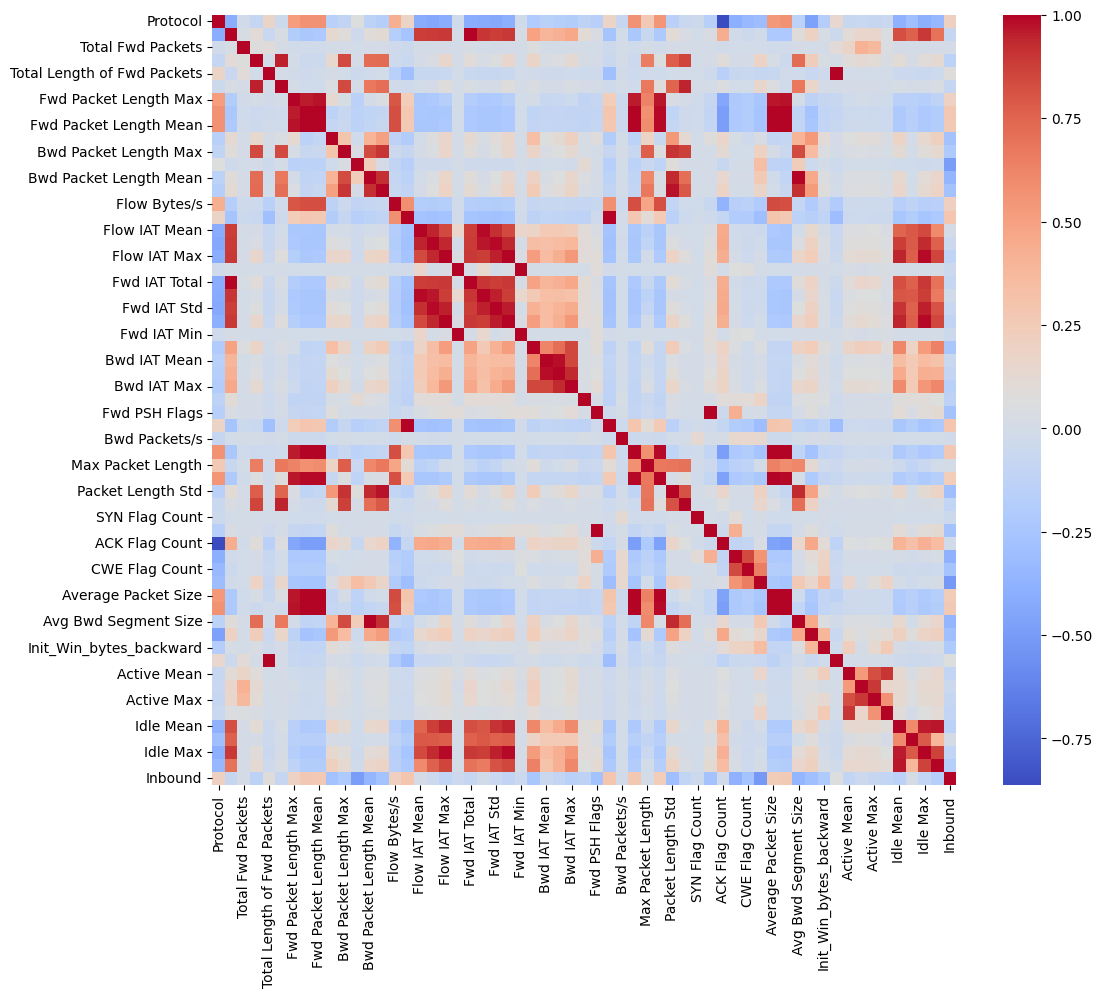

In [10]:
# Obiettivo: Identificare feature altamente correlate che potrebbero essere ridondanti o utili per il clustering

# Calcolo della matrice di correlazione
correlation_matrix = df_cleaned[numerical_features].corr()

# Heatmap della correlazione
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, cbar=True)
#plt.title('Matrice di Correlazione delle Feature Numeriche')
plt.show()


### 1.4 ECDF of the new features
First, we plot again the correlation matrix: as expected, the principal components obtained are completely uncorrelated.

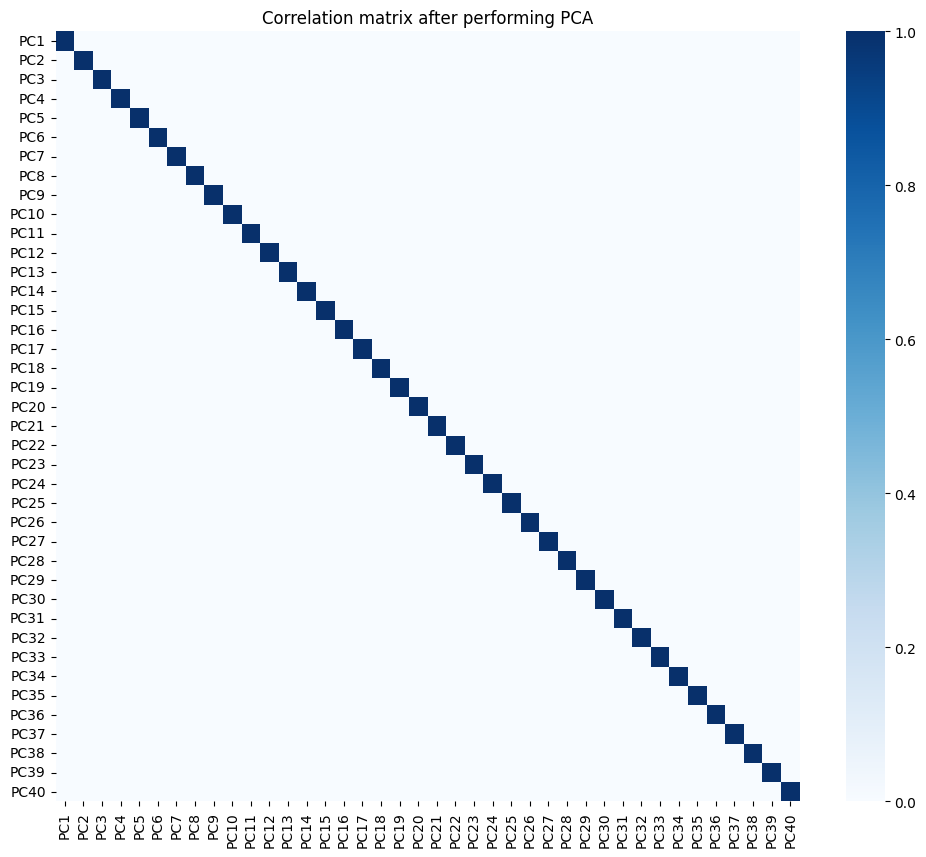

In [ ]:
correlation_matrix = df_pca1.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='Blues', annot=False, cbar=True)
plt.title('Correlation matrix after performing PCA')
plt.show()

Then we plot the ECDF of the first five principal components.

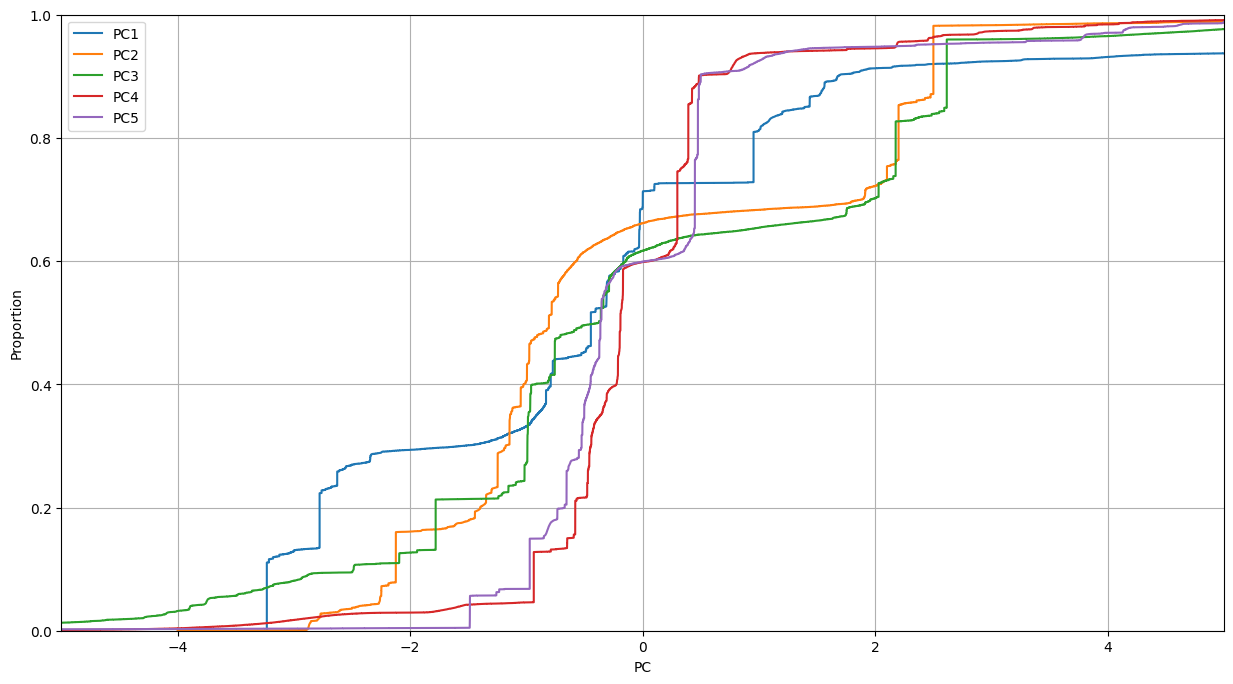

In [22]:
plt.figure(figsize=(15, 8))
for i in range(5):
    sns.ecdfplot(data=df_pca, x=f'PC{i+1}', label=f'PC{i+1}')
plt.ylabel('Proportion')

plt.xlim(-5,5)
plt.xlabel('PC')
plt.legend()
plt.grid()
plt.show()

Finally, we plot the ECDF of each PC obtained.

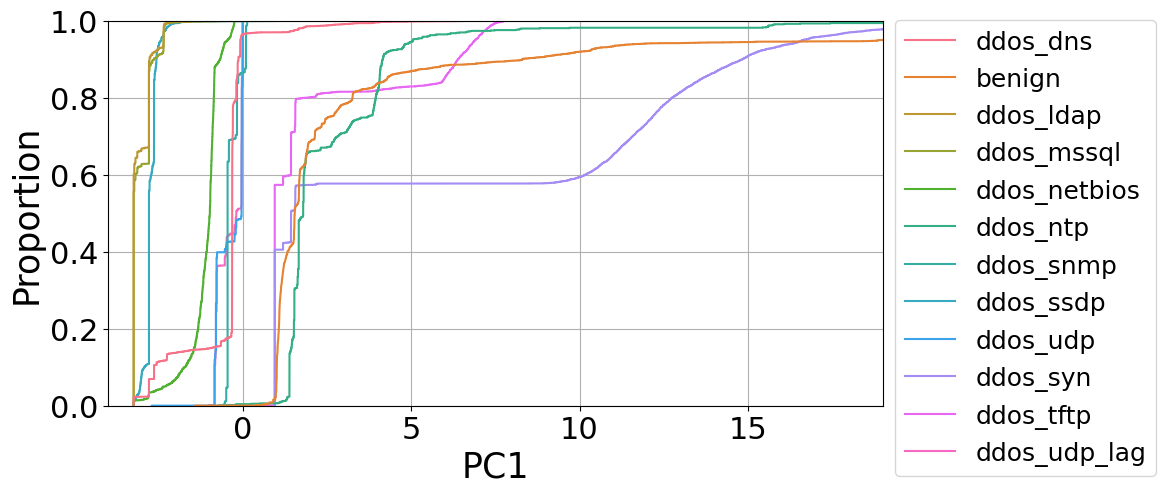

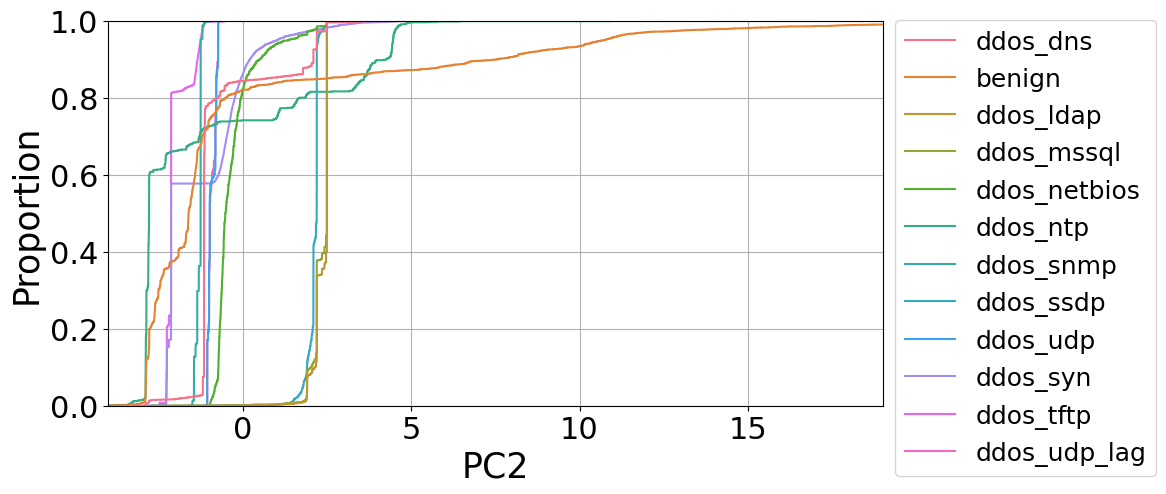

In [49]:
for i in range(2):
    plt.figure(figsize=(10, 5))
    ax=sns.ecdfplot(data=df_pca, x=f'PC{i+1}', hue='label')
    plt.xlabel(f'PC{i+1}', fontsize=25)
    plt.ylabel('Proportion', fontsize=25)
    plt.xticks(plt.tick_params(labelsize=22))
    #plt.title(f'ECDF of PC{i+1} per attack type')
    sns.move_legend(ax, bbox_to_anchor=(1, 1.035), loc="upper left", title=None, fontsize=18)
    plt.xlim(-4,19)
    plt.grid()
    plt.show()

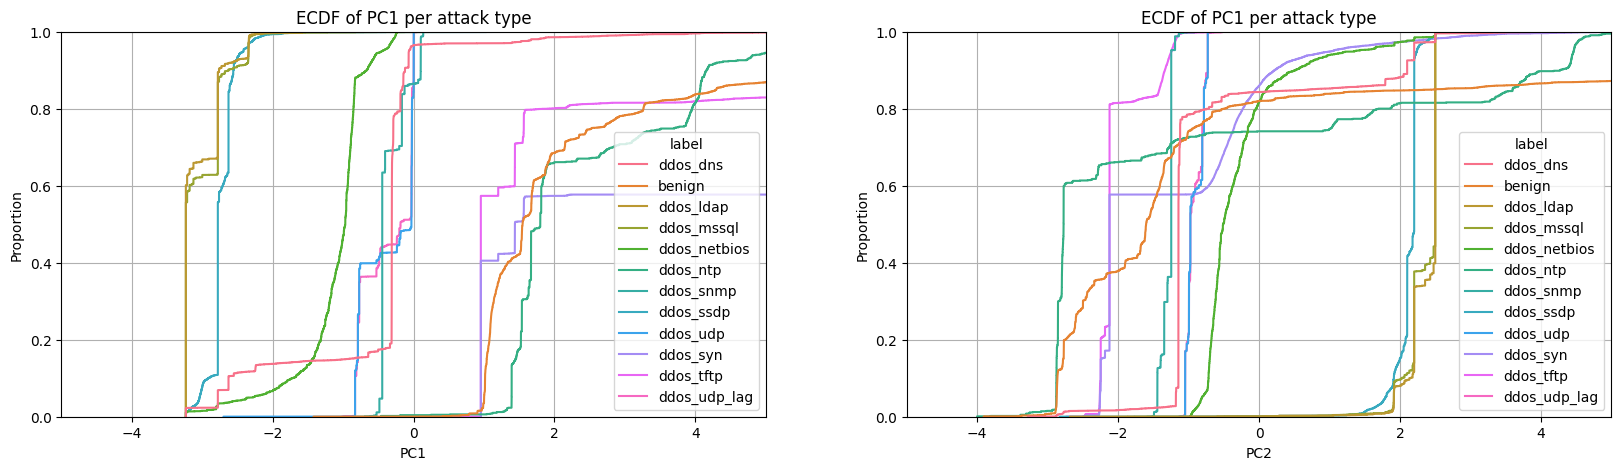

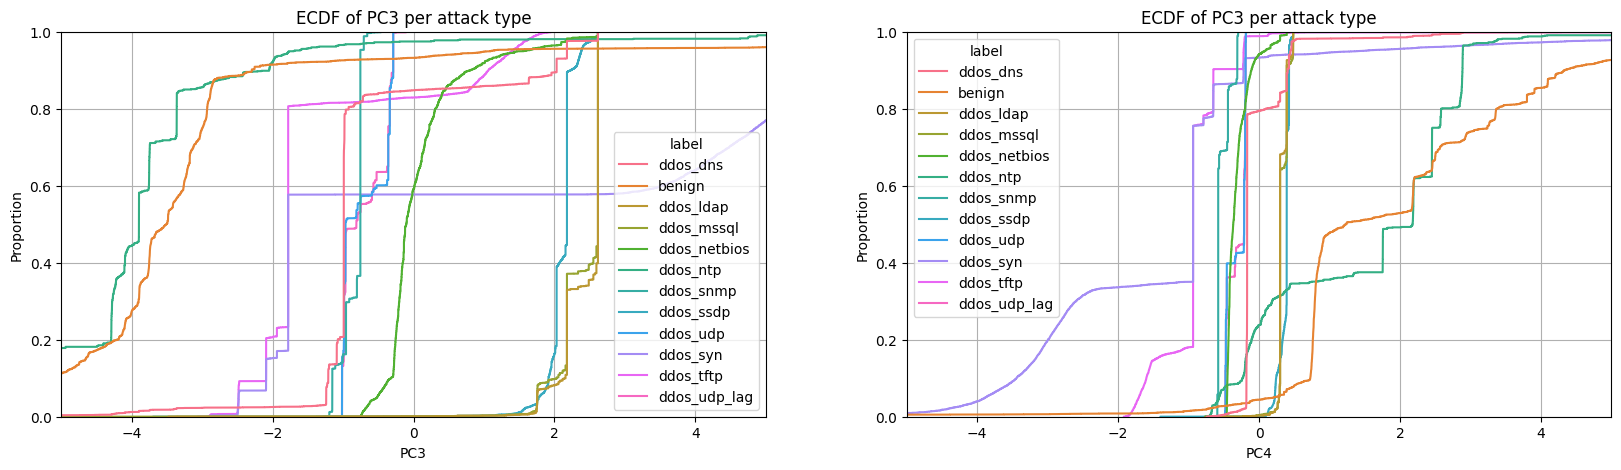

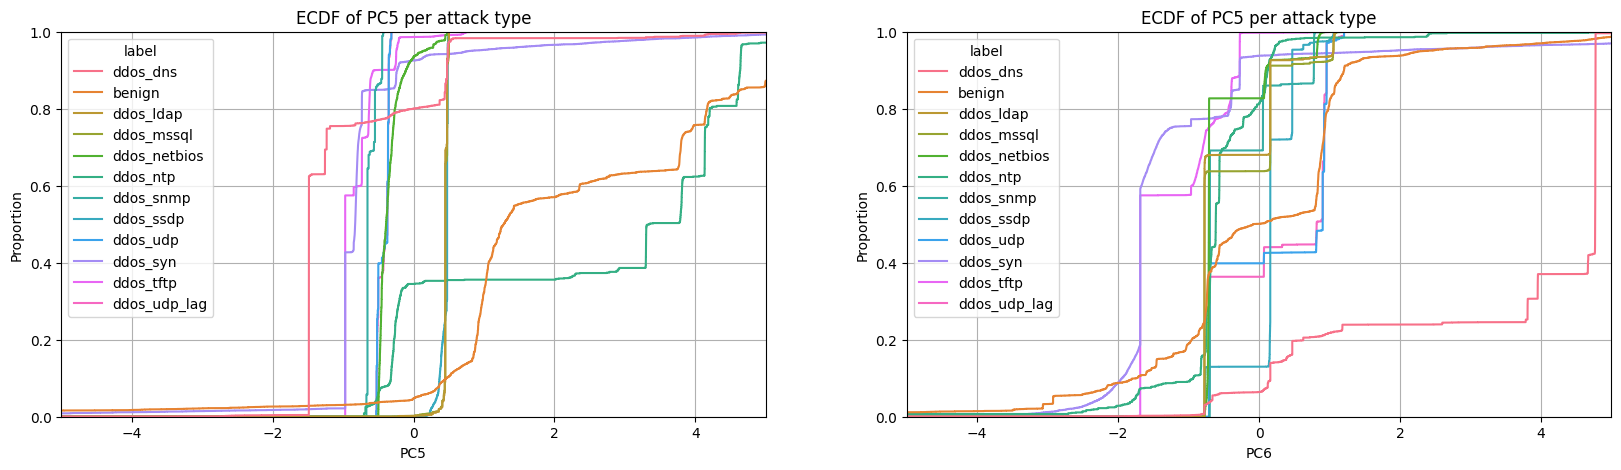

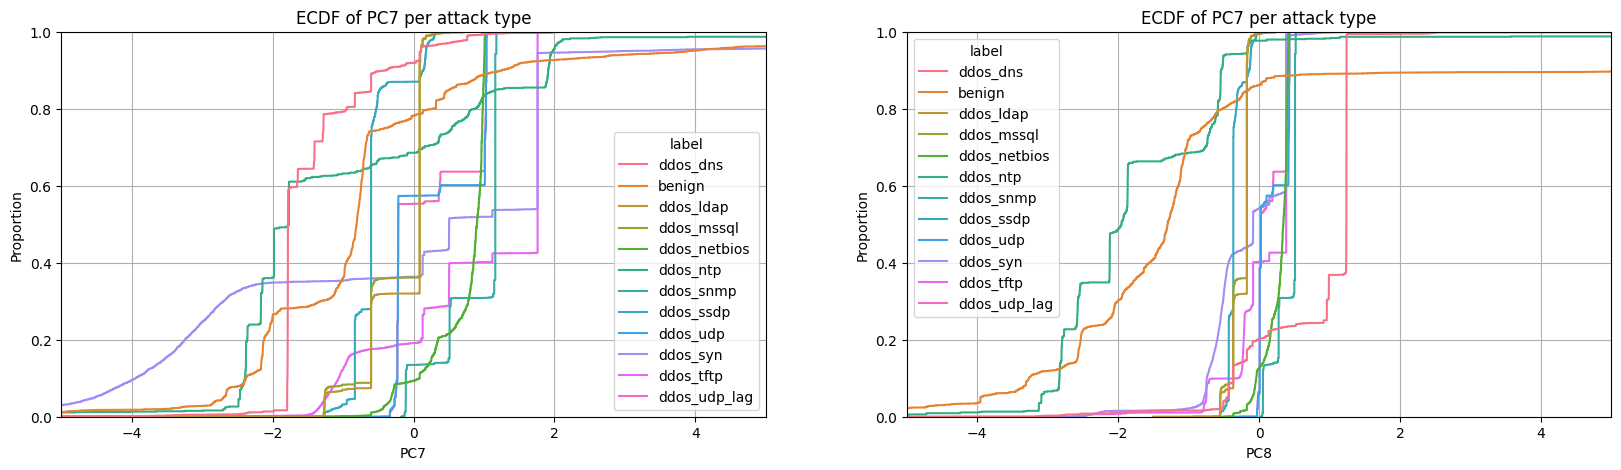

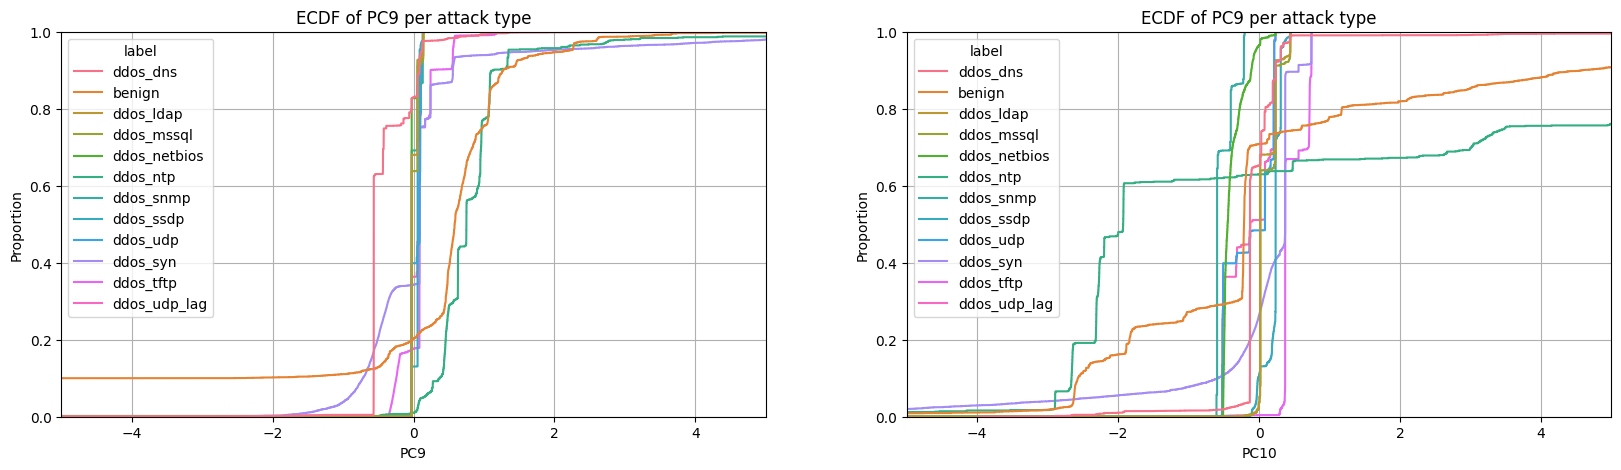

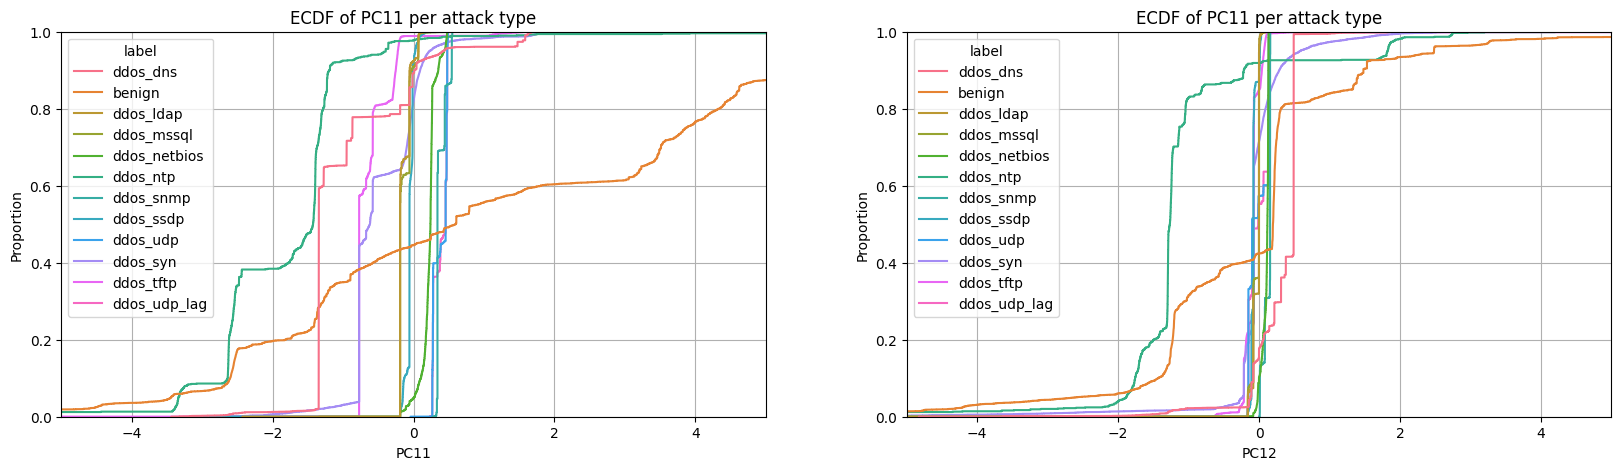

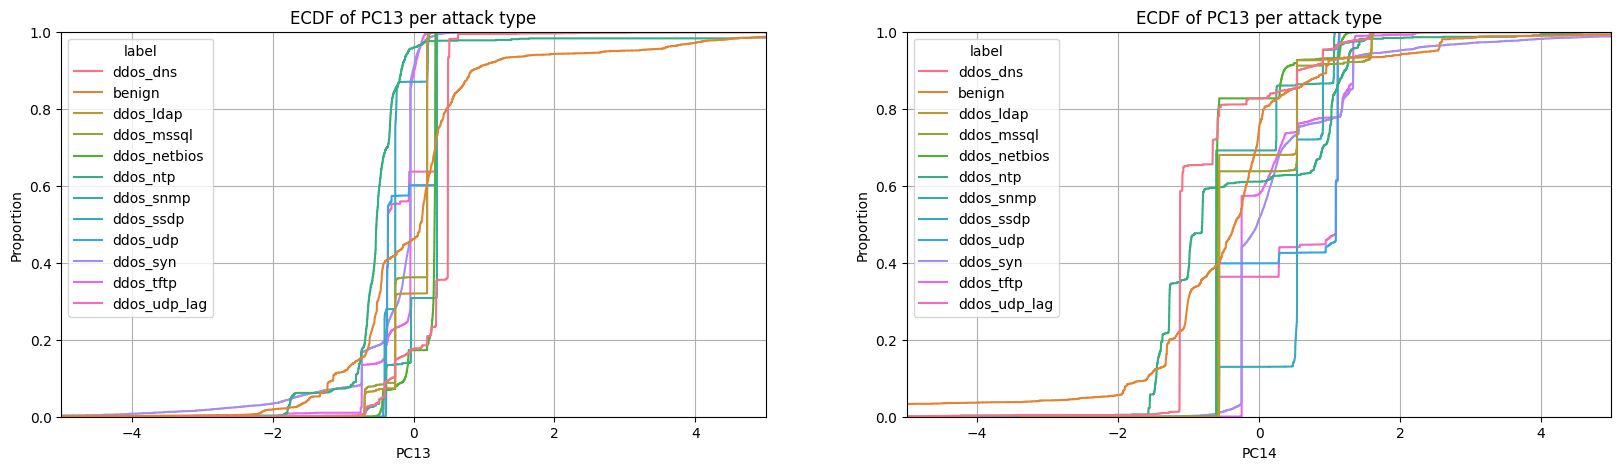

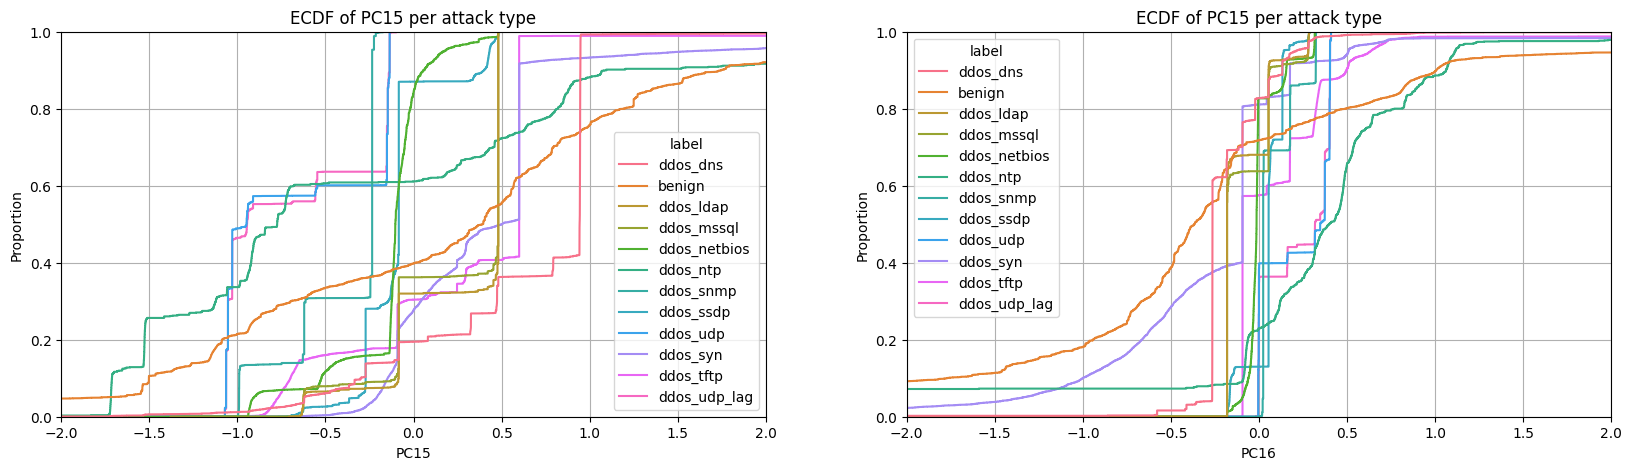

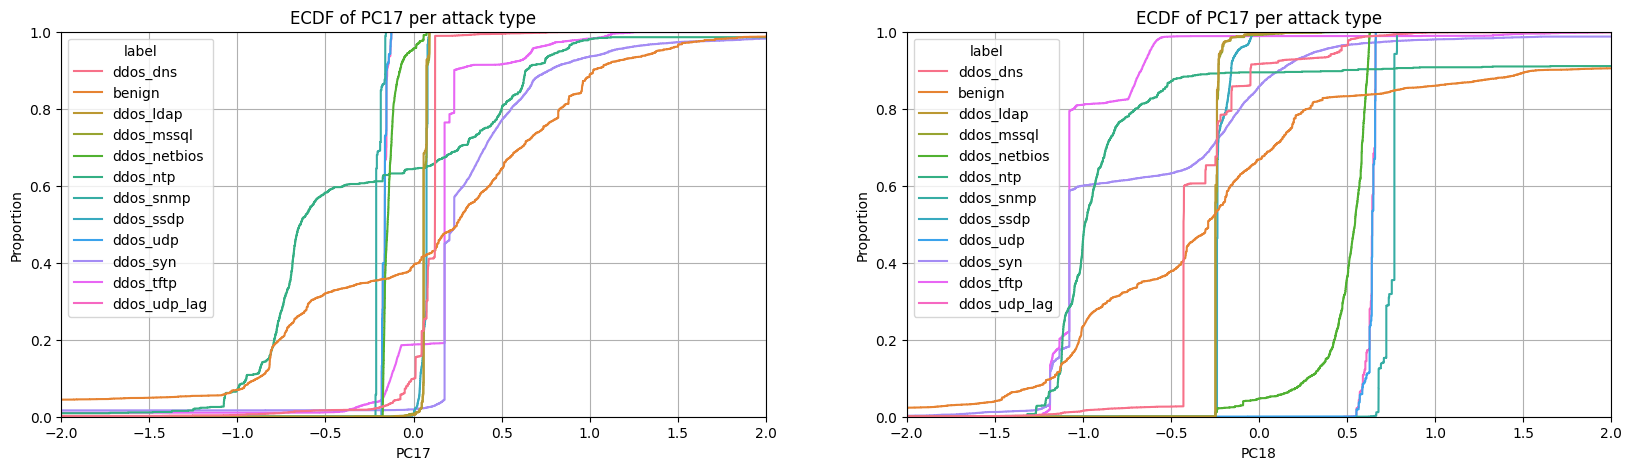

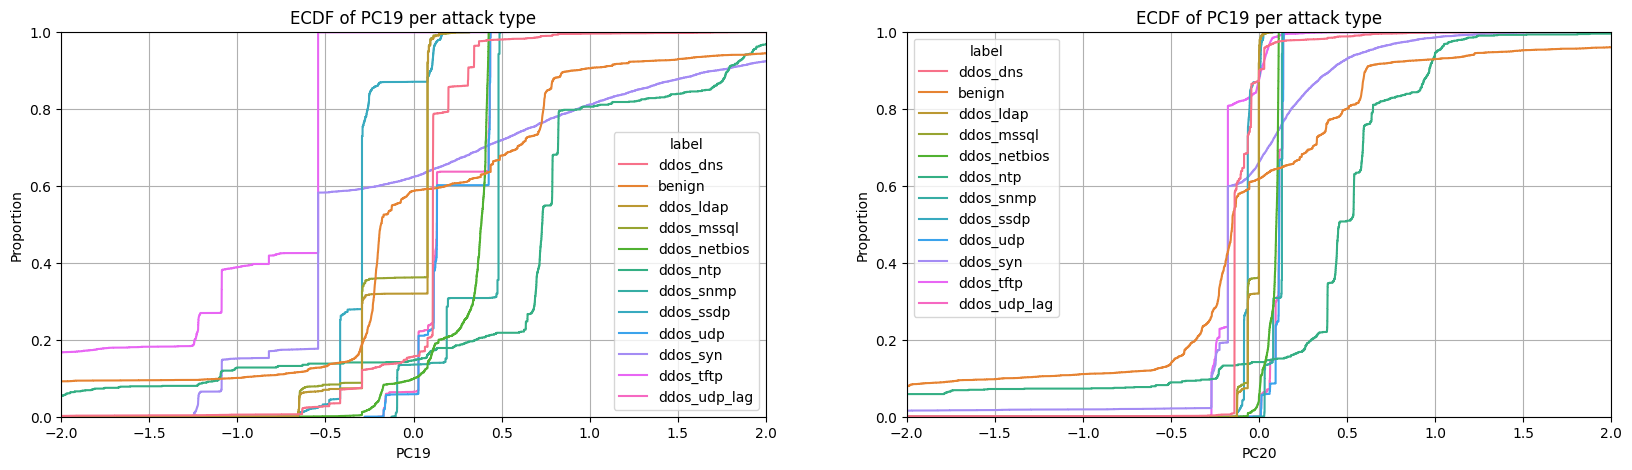

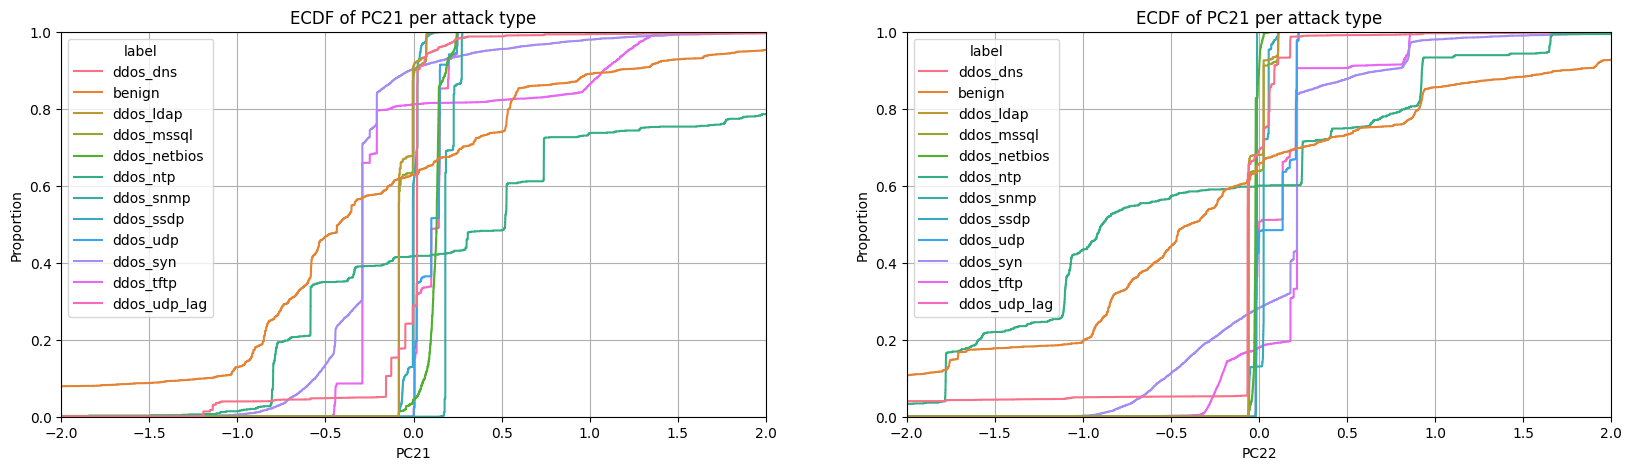

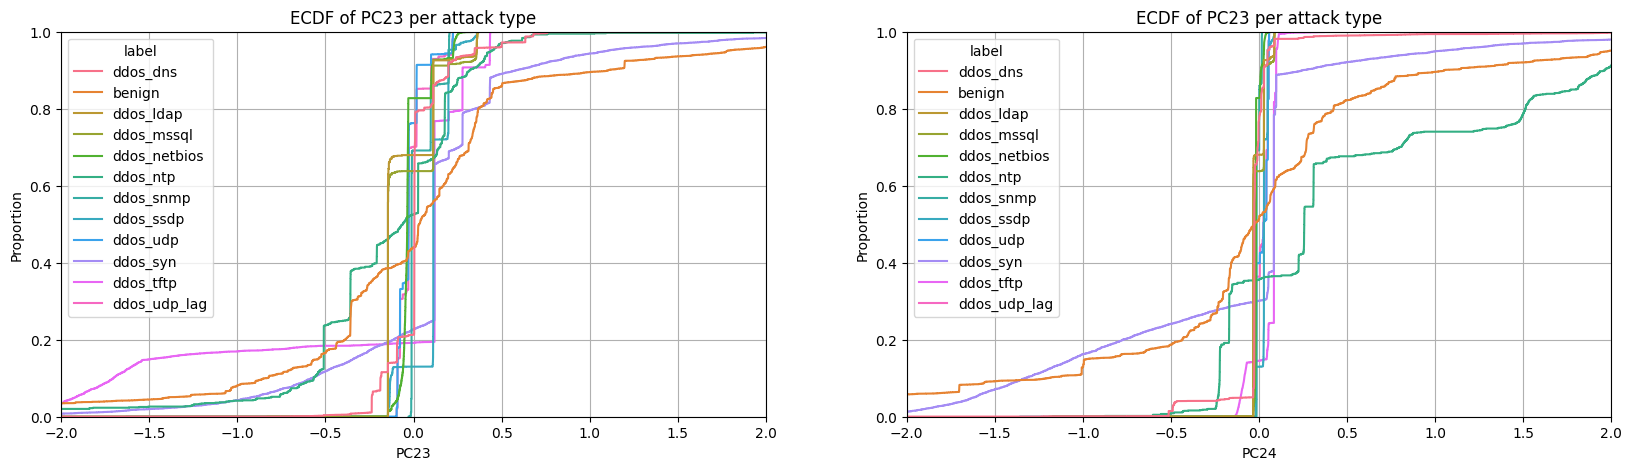

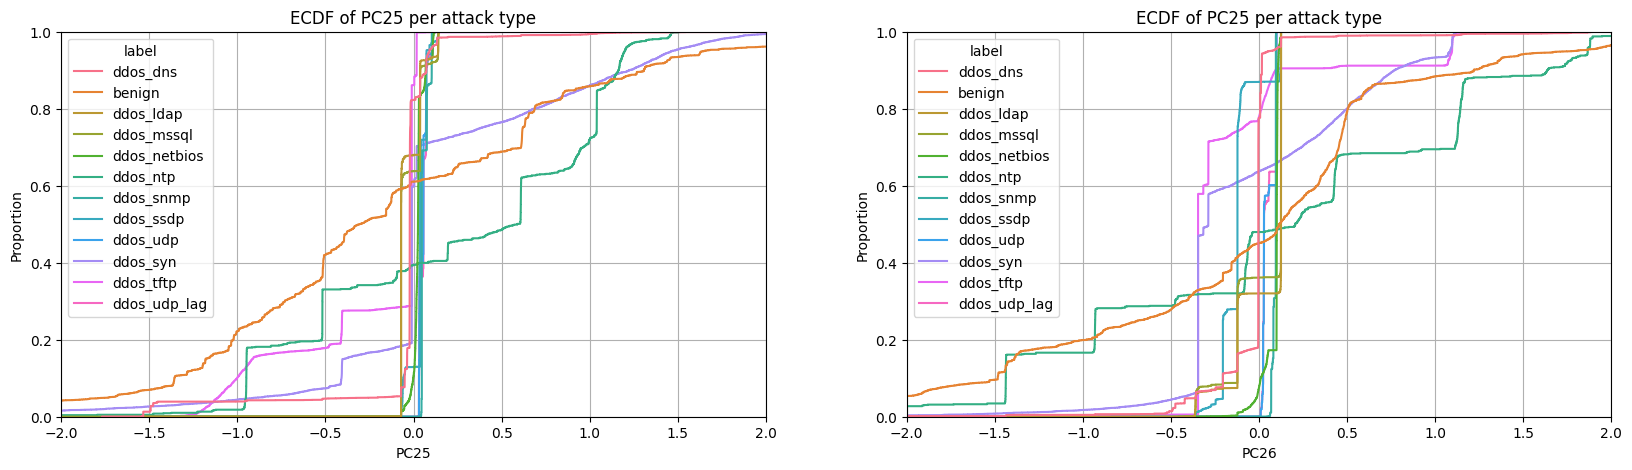

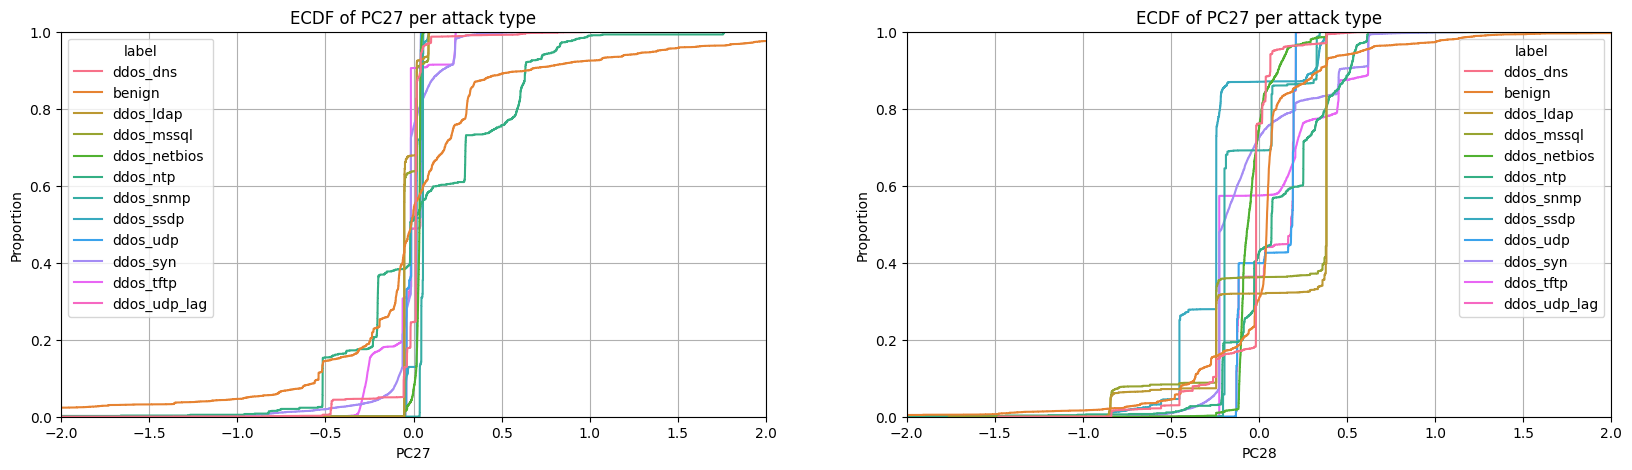

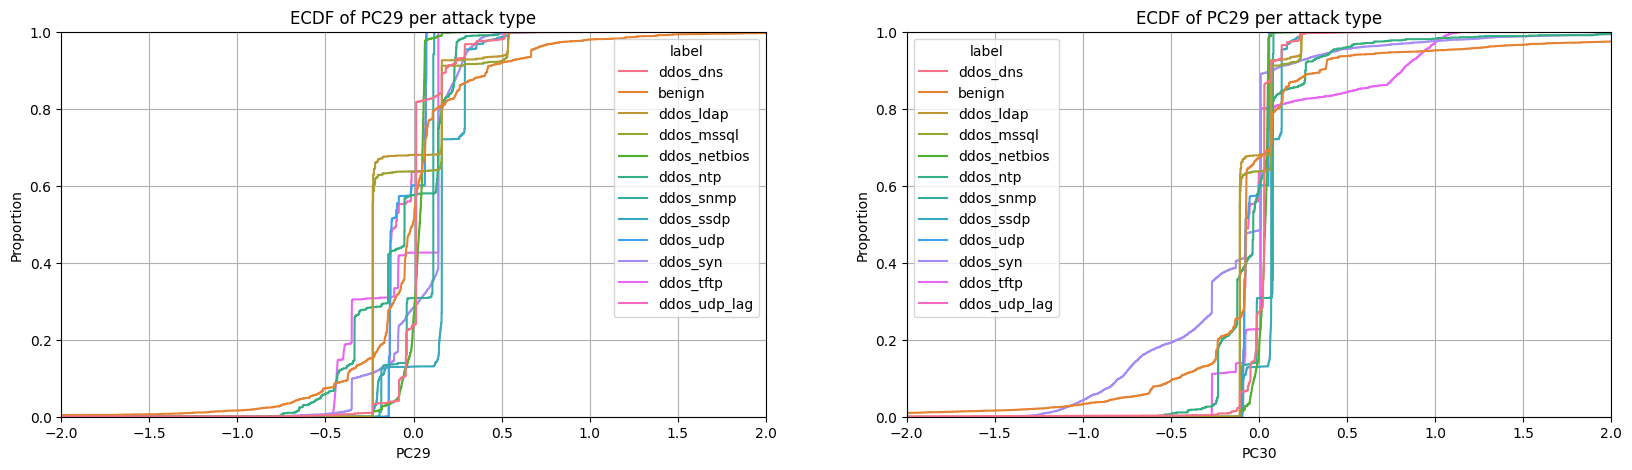

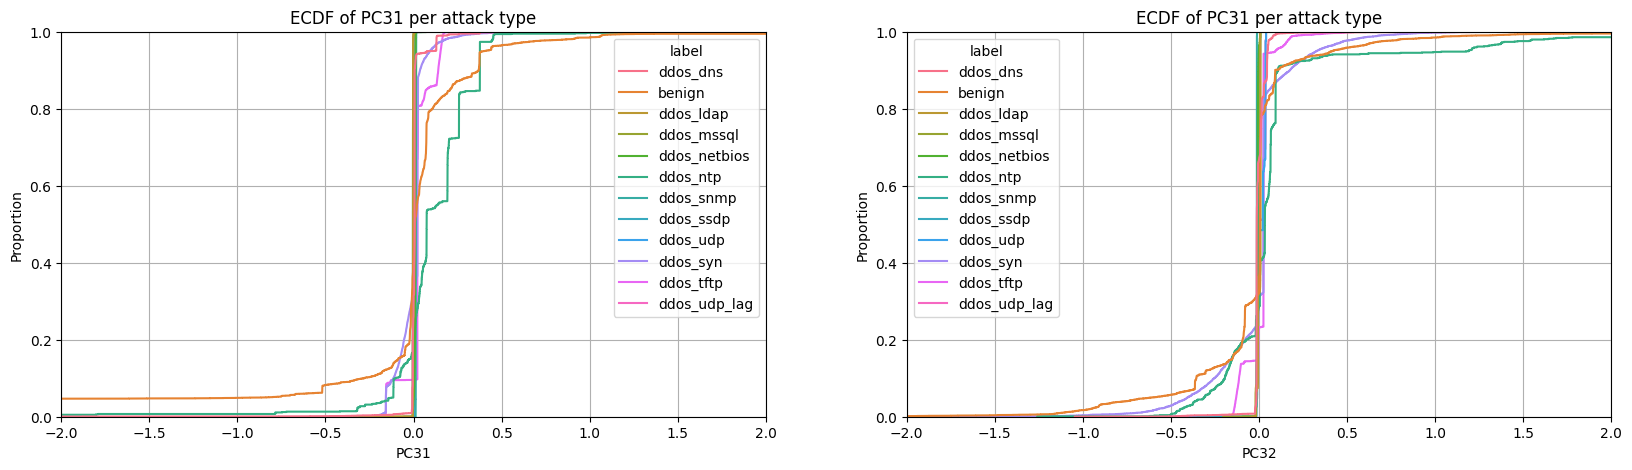

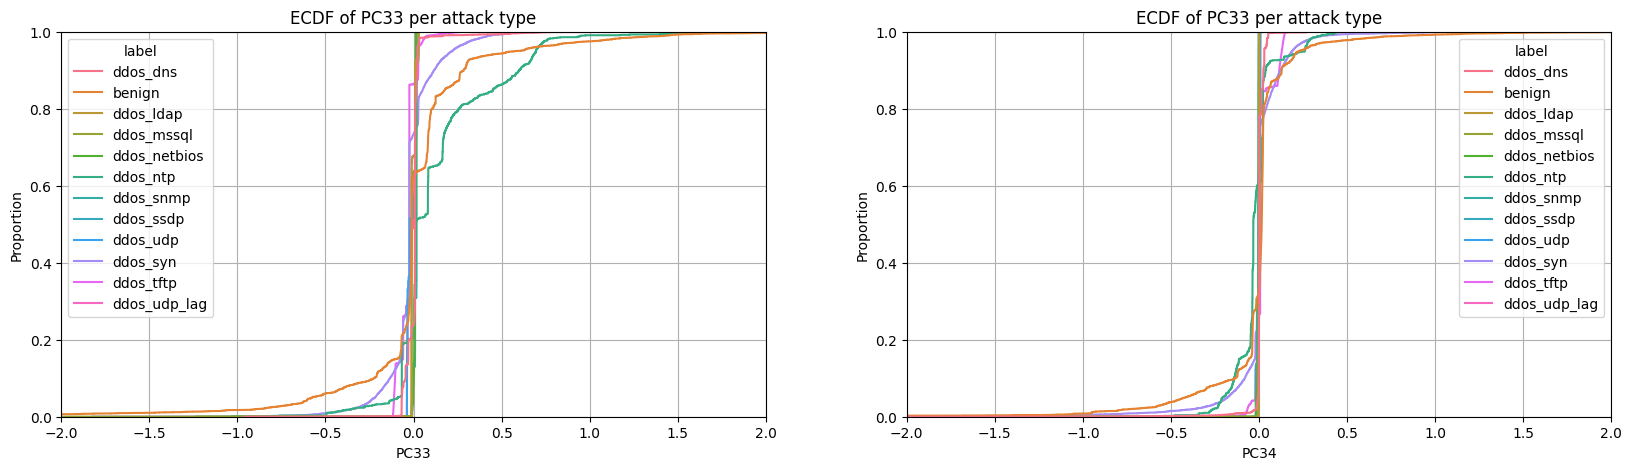

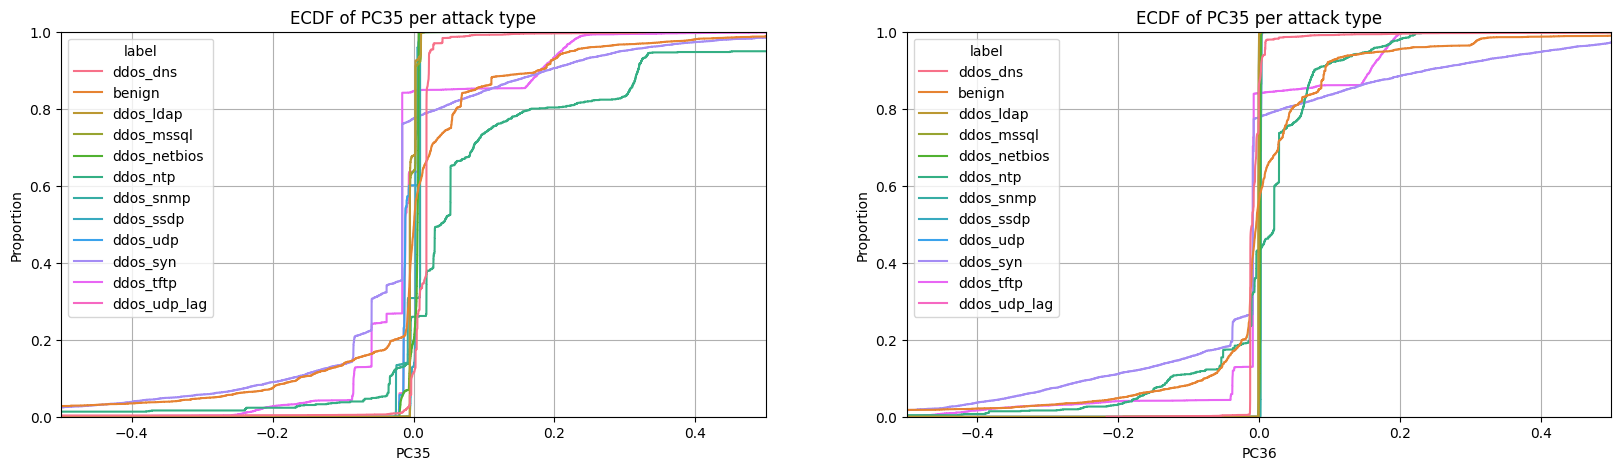

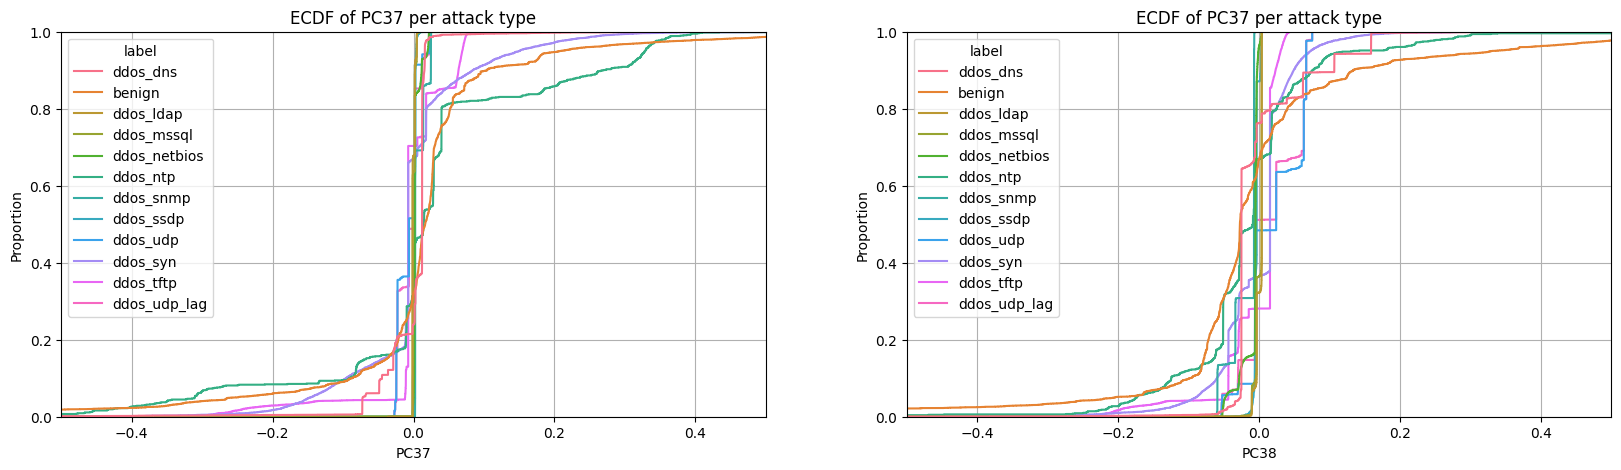

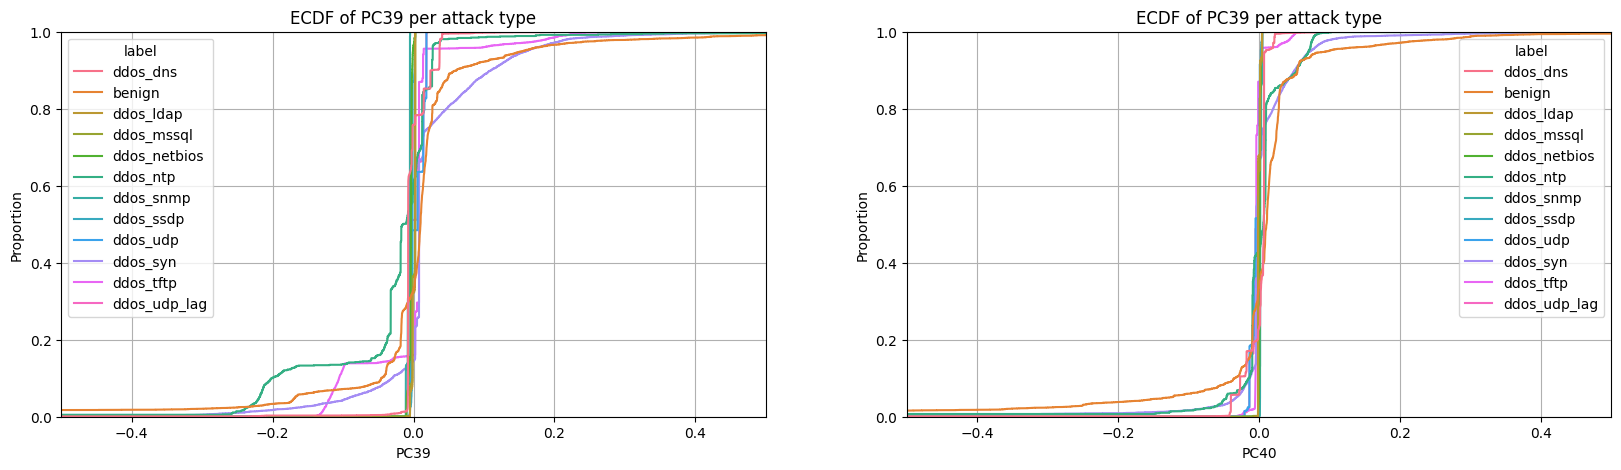

In [51]:
# ECDF of PCA feature per attack type

for i in range(1, PC_number+1, 2):
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))
    sns.ecdfplot(data=df_pca, x=f'PC{i}', hue='label', ax = axes[0])
    sns.ecdfplot(data=df_pca, x=f'PC{i+1}', hue='label', ax = axes[1])
    axes[0].set_xlabel(f'PC{i}')
    axes[1].set_xlabel(f'PC{i+1}')
    axes[0].set_ylabel('Proportion')
    axes[1].set_ylabel('Proportion')
    axes[0].set_title(f'ECDF of PC{i} per attack type')
    axes[1].set_title(f'ECDF of PC{i} per attack type')
    if i < 15:
        axes[0].set_xlim(-5,5)
        axes[1].set_xlim(-5,5)
    elif i < 35:
        axes[0].set_xlim(-2,2)
        axes[1].set_xlim(-2,2)
    else:
        axes[0].set_xlim(-0.5,0.5)
        axes[1].set_xlim(-0.5,0.5)
    axes[0].grid()
    axes[1].grid()
    plt.show()

#### 1.5 Dimensionality reduction
PCA is a great way to do dimensionality reduction, obtaining a certain number of uncorrelated features. However, it has a big disadvantage, since it reduces the explainability of our results. For this reason, here we perform dimensionality reduction simply removing highly correlated features. 

In [98]:
correlation_matrix = df_copy.drop(['Flow ID', 'Source IP', 'Destination IP', 'label', 'Timestamp', 'SimillarHTTP'], axis = 1).corr().abs()
c = correlation_matrix[correlation_matrix>0.8]
s = c.unstack()
so = s.sort_values(ascending=False).reset_index()

# get strongly correlated features removing pairs having correlation = 1 because of the diagonal, i.e., correlation between one feature and itself
so = so[(so[0].isnull()==False) & (so["level_0"] != so["level_1"])]

to_be_deleted = []
candidates = list(so["level_0"])

# get the unique set of features to be deleted. Notice that we discard one feature per time considering the case where a feature is strongly correlated with multiple features
subset_so = so
for candidate in candidates:
    if (candidate in list(subset_so["level_0"])):
        to_be_deleted.append(candidate)
        subset_so = subset_so[(subset_so["level_0"] != candidate) & (subset_so["level_1"] != candidate)]

# to_be_deleted contains the index of columns that you need to remove from both training and test sets
print("Cleaned dataset")
print(len(to_be_deleted), 'features are removed:', to_be_deleted)
print(len(df_copy.columns) - len(to_be_deleted), 'features are kept.')

preprocessed_df = df_copy.drop(to_be_deleted, axis=1)

preprocessed_df.to_csv("preprocessed_dataset.csv")

Cleaned dataset
35 features are removed: ['Avg Bwd Segment Size', 'Bwd Packet Length Mean', 'Fwd PSH Flags', 'Avg Fwd Segment Size', 'Fwd Packet Length Mean', 'Min Packet Length', 'Fwd Packet Length Min', 'Flow Duration', 'Fwd IAT Total', 'Fwd Packets/s', 'Fwd IAT Min', 'Fwd IAT Max', 'Flow IAT Max', 'Total Length of Fwd Packets', 'Packet Length Mean', 'Average Packet Size', 'Flow IAT Std', 'Fwd IAT Std', 'Fwd IAT Mean', 'Flow IAT Mean', 'Idle Max', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd Packet Length Std', 'Packet Length Std', 'Idle Min', 'Total Backward Packets', 'Total Length of Bwd Packets', 'Packet Length Variance', 'Bwd IAT Max', 'Active Min', 'Active Mean', 'Active Std', 'Protocol', 'URG Flag Count']
32 features are kept.


The next cell is only for debug purposes. Delete it when you are sure that everything is fine and we don't miss important features by cleaning our dataset.

In [ ]:
# extract features having a correlation > 0.8
correlation_matrix = df.drop(['Flow ID', 'Source IP', 'Destination IP', 'label', 'Timestamp', 'SimillarHTTP'], axis = 1).corr().abs()
c = correlation_matrix[correlation_matrix>0.8]
s = c.unstack()
so = s.sort_values(ascending=False).reset_index()

# get strongly correlated features removing pairs having correlation = 1 because of the diagonal, i.e., correlation between one feature and itself
so = so[(so[0].isnull()==False) & (so["level_0"] != so["level_1"])]

to_be_deleted = []
candidates = list(so["level_0"])

# get the unique set of features to be deleted. Notice that we discard one feature per time considering the case where a feature is strongly correlated with multiple features
subset_so = so
for candidate in candidates:
    if (candidate in list(subset_so["level_0"])):
        to_be_deleted.append(candidate)
        subset_so = subset_so[(subset_so["level_0"] != candidate) & (subset_so["level_1"] != candidate)]

# to_be_deleted contains the name of columns that you need to remove
print("Original dataset")
print(len(to_be_deleted), 'features are removed:', to_be_deleted)
print(len(df.columns) - len(to_be_deleted), 'features are kept.')
preprocessed_df1 = df.drop(to_be_deleted, axis=1)

correlation_matrix = df_copy.drop(['Flow ID', 'Source IP', 'Destination IP', 'label', 'Timestamp', 'SimillarHTTP'], axis = 1).corr().abs()
c = correlation_matrix[correlation_matrix>0.8]
s = c.unstack()
so = s.sort_values(ascending=False).reset_index()

# get strongly correlated features removing pairs having correlation = 1 because of the diagonal, i.e., correlation between one feature and itself
so = so[(so[0].isnull()==False) & (so["level_0"] != so["level_1"])]

to_be_deleted = []
candidates = list(so["level_0"])

# get the unique set of features to be deleted. Notice that we discard one feature per time considering the case where a feature is strongly correlated with multiple features
subset_so = so
for candidate in candidates:
    if (candidate in list(subset_so["level_0"])):
        to_be_deleted.append(candidate)
        subset_so = subset_so[(subset_so["level_0"] != candidate) & (subset_so["level_1"] != candidate)]

# to_be_deleted contains the index of columns that you need to remove from both training and test sets
print("Cleaned dataset")
print(len(to_be_deleted), 'features are removed:', to_be_deleted)
print(len(df_copy.columns) - len(to_be_deleted), 'features are kept.')

preprocessed_df = df_copy.drop(to_be_deleted, axis=1)

print("Differences")
print(list(set(preprocessed_df1.columns) - set(preprocessed_df.columns)))
list(set(preprocessed_df.columns) - set(preprocessed_df1.columns))

Original dataset
40 features are removed: ['Bwd Packet Length Mean', 'Avg Bwd Segment Size', 'Fwd PSH Flags', 'Fwd Header Length', 'Subflow Bwd Bytes', 'Subflow Bwd Packets', 'Subflow Fwd Bytes', 'Subflow Fwd Packets', 'Avg Fwd Segment Size', 'Fwd Packet Length Mean', 'Total Length of Bwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Min Packet Length', 'Fwd Packet Length Min', 'Flow Duration', 'Fwd IAT Total', 'Fwd Packets/s', 'Flow IAT Min', 'Flow IAT Max', 'Fwd IAT Max', 'Packet Length Mean', 'Average Packet Size', 'Flow IAT Std', 'Fwd IAT Std', 'Flow IAT Mean', 'Fwd IAT Mean', 'Idle Max', 'Bwd IAT Std', 'Bwd IAT Mean', 'Bwd Packet Length Std', 'Packet Length Std', 'Idle Mean', 'Packet Length Variance', 'Bwd IAT Max', 'Active Min', 'Active Mean', 'Active Std', 'ACK Flag Count', 'CWE Flag Count']
47 features are kept.
Cleaned dataset
35 features are removed: ['Avg Bwd Segment Size', 'Bwd Packet Length Mean', 'Fwd PSH Flags', 'Avg Fwd Segment Size', 'Fwd Packet L

['ACK Flag Count', 'Idle Mean', 'CWE Flag Count', 'Flow IAT Min']

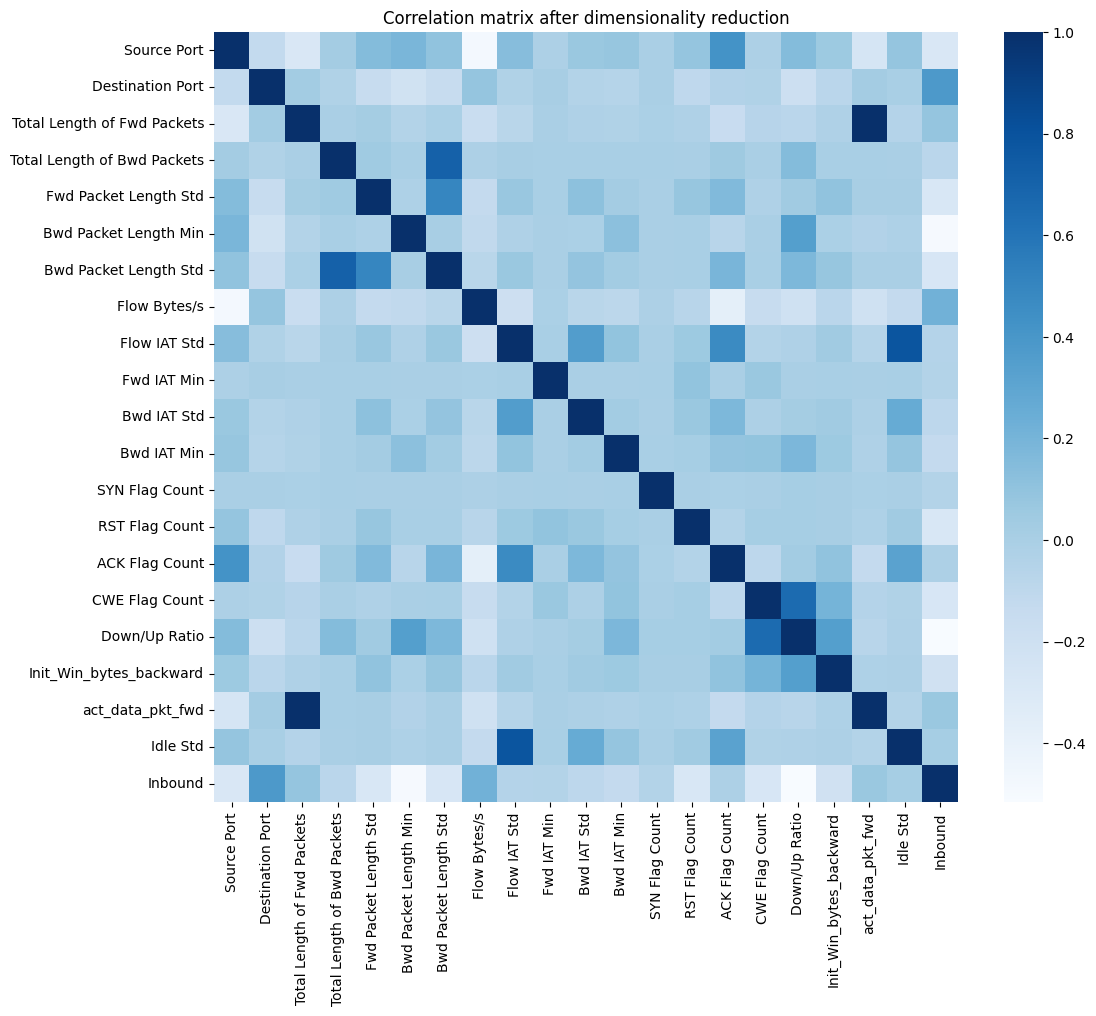

In [ ]:
correlation_matrix = preprocessed_df.drop(['Flow ID', 'Source IP', 'Destination IP', 'label', 'Timestamp', 'SimillarHTTP'], axis=1).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='Blues', annot=False, cbar=True)
plt.title('Correlation matrix after dimensionality reduction')
plt.show()